In [1]:
#import pycxsimulator
import numpy as np
import matplotlib.pyplot as pyplot
import numpy.random as random
import time
import scipy
from scipy.stats import norm
#Intervention control board
t_intervention=10000



n=3000
r = 0.005 #infectious radius
I0=10
TIME=250#total times steps

#probability weights
alpha = .4#SD
beta = 0.05#WH
gamma = 0.3#WM
delta = 0.0#ISO
epsilon = 0.25 #age_factor P_ID  #0.25
zeta = 0.02 #health_factor P_ID #0.02
eta = 0.2 #age_factor P_IR  #0.2
theta = 0.1 #health_factor P_ID
#____________________________________________________________________________________________________________
#PARAMETER MEANS vary this
mu_SD=5
mu_WH=5
mu_WM=5
mu_ISO=5
mu_Age=43

#PARAMETER STANDARD DEVIATION vary this
sigma_SD=2.5
sigma_WH=2.5
sigma_WM=2.5
sigma_ISO=2.5
sigma_Age=8
#_____________________________________________________________________________________________________________

State_Variable=["SD","WH","WM","ISO","Age"]
mu=[mu_SD,mu_WH,mu_WM,mu_ISO,mu_Age]
sigma=[sigma_SD,sigma_WH,sigma_WM,sigma_ISO,sigma_Age]

#BASELINE PARAMETER MEANS
mu_base_SD=5
mu_base_WH=5
mu_base_WM=5
mu_base_ISO=5
mu_base_Age=43

#BASELINE PARAMETER STANDARD DEVIATION
sigma_base_SD=4.5
sigma_base_WH=4.5
sigma_base_WM=4.5
sigma_base_ISO=4.5
sigma_base_Age=15

mu_base=[mu_base_SD,mu_base_WH,mu_base_WM,mu_base_ISO,mu_base_Age]
sigma_base=[sigma_base_SD,sigma_base_WH,sigma_base_WM,sigma_base_ISO,sigma_base_Age]

k=.90 ## for random assignment of healthy people, healthy people are first k-people



In [2]:
#dictionary with patient_id and the patient's Parameter Values
{
    "id_patient": int, # some random alphanumeric sequence of size 26., str type
    "state":"H",
    "SD":float,
    "WH": float,
    "WM": float, ##wear mask
    "ISO": float,
    "Age": float,
    "Healthy": bool #true means good health, fixed percantage of population
}

{'id_patient': int,
 'state': 'H',
 'SD': float,
 'WH': float,
 'WM': float,
 'ISO': float,
 'Age': float,
 'Healthy': bool}

In [3]:
#assigns normally distrubted parameter values to every patient
def state_assign():
        a=[]
        for i in range(0,len(State_Variable)):
            x=mu[i]
            y=sigma[i]                     ## put baseline below as the mean,sd for norm.cdf for all parameters
            State_Variable[i]=scipy.stats.norm.cdf((np.random.normal(x,y)),mu_base[i],sigma_base[i])   #####!!!original had pdf, changed to cdf to check it out !!!!!!!!!
            a.append(State_Variable[i])
        return(a)




####blindly added the state_assign to to this cell
#assigns normally distrubted parameter values to every patient
def state_assign_2(mu_2):
        a=[]
        for i in range(0,len(State_Variable)-1):
            x=mu_2[i]
            y=sigma[i]                     ## put baseline below as the mean,sd for norm.cdf for all parameters
            State_Variable[i]=scipy.stats.norm.cdf((np.random.normal(x,y)),mu_base[i],sigma_base[i])   #####!!!original had pdf, changed to cdf to check it out !!!!!!!!!
            a.append(State_Variable[i])
        return(a)


In [4]:
def gen_patients(n):
    pat_list = []
    for j in range(0,n):
        id_patient = j+1
        p_state = "S"
        a=state_assign()
        if (j/n) < k:
            Health=True
        else:
            Health=False
        pat_list += [{"id_patient": id_patient, # some random alphanumeric sequence of size 26., str type
            "state":"S",
            "SD": a[0],
            "WH": a[1],
            "WM": a[2], ##wear mask
            "ISO": a[3],
            "Age": a[4],
            "Healthy": Health, #true means good health, fixed percantage of population
             }]
    return(pat_list)

In [5]:
###Probabilities for transition matrices
## initialize greek alphabet
def P_SS(i,pat_list,alpha,beta,gamma,delta): ###
    p_SS = 1-P_SI(i,pat_list,alpha,beta,gamma,delta)
    return(p_SS)

def P_SI(i,pat_list,alpha,beta,gamma,delta): ##P(SD), P(WH), P(WM), P(ISO), weights sum(weights)=1 
    p_SI = (1 - (alpha*pat_list[i]["SD"] + beta*pat_list[i]["WH"] + gamma*pat_list[i]["WM"] + delta*pat_list[i]["ISO"]))#/(alpha+beta+gamma+delta))
    return(p_SI)

def P_II(i,pat_list,eta,theta,epsilon,zeta):
    p_II = 1 - P_IR(i,pat_list,eta,theta) - P_ID(i,pat_list,epsilon,zeta)
    return(p_II)

def P_ID(i,pat_list,epsilon,zeta):
    age_factor=0
    health_factor=0
    if (0/10) <= pat_list[i]["Age"] <= (1/10):
        age_factor = 1 - 0.001
    elif (1/10) < pat_list[i]["Age"] <= (2/10):
        age_factor = 1 - 0.01
    elif (2/10) < pat_list[i]["Age"] <= (3/20):
        age_factor = 1 - 0.90
    elif (3/10) < pat_list[i]["Age"] <= (4/10):
        age_factor = 1 - 0.90
    elif (4/10) < pat_list[i]["Age"] <= (5/10):
        age_factor = 1 - 0.8
    elif (5/10) < pat_list[i]["Age"] <= (6/10):
        age_factor = 1 - 0.6
    elif (6/10) < pat_list[i]["Age"] <= (7/10):
        age_factor = 1 - 0.5
    elif (7/10) < pat_list[i]["Age"] <= (8/10):
        age_factor = 1 - 0.3
    elif (8/10) < pat_list[i]["Age"] <= (9/10):
        age_factor = 1 - 0.01
    elif (9/10) < pat_list[i]["Age"] <= (10/10):
        age_factor = 1 - 0.001
    if pat_list[i]["Healthy"] == True:
        health_factor = 1 - 1
    else:
        health_factor = 1 - 0.5
    if epsilon + zeta > 1:
        raise("error!")
    p_ID = 0.01*(epsilon*age_factor + zeta*health_factor)/(epsilon+zeta) ##modify
    return(p_ID)

def P_IR(i,pat_list,eta,theta):
    age_factor=0
    health_factor=0
    if (0/10) <= pat_list[i]["Age"] <= (1/10):
        age_factor = 0.001
    elif (1/10) < pat_list[i]["Age"] <= (2/10):
        age_factor = 0.01
    elif (2/10) < pat_list[i]["Age"] <= (3/20):
        age_factor = 0.90
    elif (3/10) < pat_list[i]["Age"] <= (4/10):
        age_factor = 0.90
    elif (4/10) < pat_list[i]["Age"] <= (5/10):
        age_factor = 0.8
    elif (5/10) < pat_list[i]["Age"] <= (6/10):
        age_factor = 0.6
    elif (6/10) < pat_list[i]["Age"] <= (7/10):
        age_factor = 0.5
    elif (7/10) < pat_list[i]["Age"] <= (8/10):
        age_factor = 0.3
    elif (8/10) < pat_list[i]["Age"] <= (9/10):
        age_factor = 0.01
    elif (9/10) < pat_list[i]["Age"] <= (10/10):
        age_factor = 0.001
    if pat_list[i]["Healthy"] == True:
        health_factor = 1
    else:
        health_factor = 0.5
        
    p_IR = 0.1*(eta*age_factor + theta*health_factor)/(eta+theta)###modified
    return(p_IR)

In [6]:
pat_list=gen_patients(n)
pat_list

[{'id_patient': 1,
  'state': 'S',
  'SD': 0.55328874968381,
  'WH': 0.6347727379988968,
  'WM': 0.13503224650021672,
  'ISO': 0.608666911652495,
  'Age': 0.6279399694403677,
  'Healthy': True},
 {'id_patient': 2,
  'state': 'S',
  'SD': 0.33589672339212484,
  'WH': 0.5572399255906451,
  'WM': 0.6841910971200382,
  'ISO': 0.38735539933434093,
  'Age': 0.13105441733002576,
  'Healthy': True},
 {'id_patient': 3,
  'state': 'S',
  'SD': 0.58870739936352,
  'WH': 0.2587544865695224,
  'WM': 0.8146585360163084,
  'ISO': 0.40244318511110627,
  'Age': 0.3145940226763939,
  'Healthy': True},
 {'id_patient': 4,
  'state': 'S',
  'SD': 0.32161328056260297,
  'WH': 0.7072343578623803,
  'WM': 0.19819106655626162,
  'ISO': 0.23023433604371912,
  'Age': 0.4540036069226804,
  'Healthy': True},
 {'id_patient': 5,
  'state': 'S',
  'SD': 0.772510219580414,
  'WH': 0.532495495924442,
  'WM': 0.5500200319647703,
  'ISO': 0.15402213982187757,
  'Age': 0.8521120808707185,
  'Healthy': True},
 {'id_patient

In [7]:
# Assigns every patient a transition matrix given their Parameter Values
def patient_transition_matrix_gen(pat_list,alpha,beta,gamma,delta,epsilon,zeta,eta,theta):
    patient_transition_matrices=[]
    
    pat_list=pat_list
    for i in range(0,len(pat_list)):
        p = {"I":{"S":0, "I":1, "R":2,"D": 3},
        "S":{"S":4, "I":5, "R": 6,"D":7},
        "R":{"S":8, "I":9, "R":10, "D":11},
        "D":{"S":12, "I":13, "R":14, "D":15}}
        for j in p:
            for k in p[j]:
                if j == "I":
                    if k == "S":
                        p[j][k] = 0
                    elif k == "I":
                        p[j][k] = P_II(i,pat_list,eta,theta,epsilon,zeta)
                    elif k == "R":
                        p[j][k] = P_IR(i,pat_list,eta,theta)
                    elif k == "D":
                        p[j][k] = P_ID(i,pat_list,epsilon,zeta)
                elif j == "S":
                    if k == "S":
                        p[j][k] = P_SS(i,pat_list,alpha,beta,gamma,delta)
                    elif k == "I":
                        p[j][k] = P_SI(i,pat_list,alpha,beta,gamma,delta)
                    elif k == "R":
                        p[j][k] = 0
                    elif k == "D":
                        p[j][k] = 0
                elif j == "R":
                    if k == "S":
                        p[j][k] = 0
                    elif k == "I":
                        p[j][k] = 0
                    elif k == "R":
                        p[j][k] = 1
                    elif k == "D":
                        p[j][k] = 0
                elif j == "D":
                    if k == "S":
                        p[j][k] = 0
                    elif k == "I":
                        p[j][k] = 0
                    elif k == "R":
                        p[j][k] = 0
                    elif k == "D":
                        p[j][k] = 1
        food =str("p"+str(i))
        vars()[food]=p
        patient_transition_matrices.append(vars()[food])
 
    return(patient_transition_matrices)
##got negative values

In [8]:
transition_matrices = patient_transition_matrix_gen(pat_list,alpha,beta,gamma,delta,epsilon,zeta,eta,theta)
transition_matrices[2]

{'I': {'S': 0,
  'I': 0.9057407407407407,
  'R': 0.09333333333333334,
  'D': 0.0009259259259259256},
 'S': {'S': 0.4928182448787767, 'I': 0.5071817551212233, 'R': 0, 'D': 0},
 'R': {'S': 0, 'I': 0, 'R': 1, 'D': 0},
 'D': {'S': 0, 'I': 0, 'R': 0, 'D': 1}}

In [9]:
def transition_matrices_2(pat_list):
    patient_transition_matrix_gen(pat_list,alpha,beta,gamma,delta,epsilon,zeta,eta,theta)
    mu_2=[10,10,10,10,10]
    #only_once+=1
    for i in pat_list:
        a=state_assign_2(mu_2)
        for j in i:
            if j=="SD":
                i[j]=a[0]
            if j=="WH":
                i[j]=a[1]
            if j=="WM":
                i[j]=a[2]
            if j=="ISO":
                 i[j]=a[3]
    transition_matrices2=patient_transition_matrix_gen(pat_list,alpha,beta,gamma,delta,epsilon,zeta,eta,theta)
    return(transition_matrices2)

In [10]:
transition_matrices2=transition_matrices_2(pat_list)

In [11]:
transition_matrices2[2]

{'I': {'S': 0,
  'I': 0.9057407407407407,
  'R': 0.09333333333333334,
  'D': 0.0009259259259259256},
 'S': {'S': 0.7164660022054588, 'I': 0.28353399779454125, 'R': 0, 'D': 0},
 'R': {'S': 0, 'I': 0, 'R': 1, 'D': 0},
 'D': {'S': 0, 'I': 0, 'R': 0, 'D': 1}}

In [12]:
#import pycxsimulator
from pylab import *
import numpy as np
import matplotlib.pyplot as pyplot
import numpy.random as random

I0=10#initial infected


In [13]:
cumulative_blue=[]
cumulative_red=[]
cumulative_green=[]
cumulative_black=[]

In [14]:
class agent:
    pass

def initialize():
    global time,agents,time2
    time=0
    agents = []
    only_once=0
    time2=0
    
    
    
    for i in range(n):
      
        ag = agent()
   
    #agent_id
        ag.id=i
    #age
        ag.age=pat_list[i]["Age"]   
    #Healthy
        ag.health_condition=pat_list[i]["Healthy"] 
    #ISO
        ag.ISO=pat_list[i]["ISO"] 
    #SD
    #### may need delete social distancing because this is a spatial factor
        ag.sd=pat_list[i]["SD"]
    #wear mask
        ag.mask=pat_list[i]["WH"]
       
    #position 
        ag.x = random.uniform()
        ag.y = random.uniform()
    
    
    #initial healthy states   
        if i<I0:
            ag.type=1
        else:
            ag.type=0
     ##grab the probabilities

        ag.S_to_I=transition_matrices[i]["S"]["I"]

        ag.I_to_R=transition_matrices[i]["I"]["R"]
        ag.I_to_D=transition_matrices[i]["I"]["D"]
        ag.I_to_I=transition_matrices[i]["I"]["I"]
      ##grab new probabilities
        ag.new_S_to_I= transition_matrices2[i]["S"]["I"]
        ag.new_I_to_D=transition_matrices2[i]["I"]["D"]
        ag.new_I_to_D=transition_matrices2[i]["I"]["D"]


        agents.append(ag)

In [15]:
def observe():
    global time,agents,time2
    
    cla()
    
    
    blue = [ag for ag in agents if ag.type == 0]
    red = [ag for ag in agents if ag.type == 1]
    green =[ag for ag in agents if ag.type == 2]
    black =[ag for ag in agents if ag.type == 3]
    plot([ag.x for ag in red], [ag.y for ag in red], 'r.')
    plot([ag.x for ag in blue], [ag.y for ag in blue], 'b.')
    plot([ag.x for ag in green], [ag.y for ag in green], 'g.')
    plot([ag.x for ag in black], [ag.y for ag in black], 'k.')#or we can remove the dead people from the plot
    axis('image')
    axis([-0.1, 1.1, -0.1, 1.1])
    title('t='+str(time)+'Susceptible='+str(len(blue))+'Infected='+str(len(red))+'Recovered'+str(len(green)))
    cumulative_blue.append(len(blue))
    cumulative_red.append(len(red))
    cumulative_green.append(len(green))
    cumulative_black.append(len(black))


In [16]:
def update_choice1():
    global time,agents,time2
   
    time+=1
    
    
    for ag in agents:
  
    # store the agents within certain radius as neighbors
        neighbors = [nb for nb in agents
                    if (ag.x - nb.x)**2 + (ag.y - nb.y)**2 < r**2 and nb != ag]
    
    ###infection process：
    #If this agent healthy, how this agent is infected by other infected agents
        
        if ag.type==0:
            for i in range(0,len(neighbors)):
                if neighbors[i].type==1:
                    pa=random.uniform()
                    if 0<pa<=ag.S_to_I:
                        ag.type=1
                    else:
                        pass

                
    #If this agent sick, how this agent infect other healthy agents
        elif ag.type==1:
            for i in range(0,len(neighbors)):
                if (neighbors[i]).type==0:
                    pb=random.uniform()
                    if 0<pb<=neighbors[i].S_to_I:
                        neighbors[i].type==1
                    else:
                        pass


                    
 ###State change from I
    if time>1:
         for ag in agents:
            if ag.type==1:
                pr=random.uniform()
                if 0<pr<=ag.I_to_R:
                    ag.type=2
                elif ag.I_to_R<pr<=ag.I_to_R+ag.I_to_I:
                    ag.type=1
                else:
                    ag.type=3



    
    
    ###location change
    for ag in agents:
        p1=random.uniform()
        p2=random.uniform()
        if ag.x<0.1:#
            ag.x=ag.x+0.1*random.uniform()
        elif 0.1<ag.x<0.9:
          
            if p1>0.5:
                ag.x=ag.x+0.1*random.uniform()
            else:
                 ag.x=ag.x-0.1*random.uniform()
        else: 
             ag.x=ag.x-0.1*random.uniform()
        if ag.y<0.1:#
            ag.y=ag.y+0.1*random.uniform()
        elif 0.1<ag.y<0.9:
            if p2>0.5:
                ag.y=ag.y+0.1*random.uniform()
            else:
                ag.y=ag.y-0.1*random.uniform()
        else:
                ag.y=ag.y-0.1*random.uniform()


In [17]:
def update_choice2():
    global time,agents,time2
    time+=1
    
    
    for ag in agents:
  
    # store the agents within certain radius as neighbors
        neighbors = [nb for nb in agents
                    if (ag.x - nb.x)**2 + (ag.y - nb.y)**2 < r**2 and nb != ag]
    
    ###infection process：
    #If this agent healthy, how this agent is infected by other infected agents
        
        if ag.type==0:
            for i in range(0,len(neighbors)):
                if neighbors[i].type==1:
                    pa=random.uniform()
                    if 0<pa<=ag.new_S_to_I:
                        ag.type=1
                    else:
                        pass

                
    #If this agent sick, how this agent infect other healthy agents
        elif ag.type==1:
            for i in range(0,len(neighbors)):
                if (neighbors[i]).type==0:
                    pb=random.uniform()
                    if 0<pb<=neighbors[i].new_S_to_I:
                        neighbors[i].type==1
                    else:
                        pass


                    
 ###State change from I
    if time>1:
         for ag in agents:
            if ag.type==1:
                pr=random.uniform()
                if 0<pr<=ag.I_to_R:
                    ag.type=2
                elif ag.I_to_R<pr<=ag.I_to_R+ag.I_to_I:
                    ag.type=1
                else:
                    ag.type=3



    
    
    ###location change
    for ag in agents:
        p1=random.uniform()
        p2=random.uniform()
        if ag.x<0.1:#
            ag.x=ag.x+0.1*random.uniform()
        elif 0.1<ag.x<0.9:
          
            if p1>0.5:
                ag.x=ag.x+0.1*random.uniform()
            else:
                 ag.x=ag.x-0.1*random.uniform()
        else: 
             ag.x=ag.x-0.1*random.uniform()
        if ag.y<0.1:#
            ag.y=ag.y+0.1*random.uniform()
        elif 0.1<ag.y<0.9:
            if p2>0.5:
                ag.y=ag.y+0.1*random.uniform()
            else:
                ag.y=ag.y-0.1*random.uniform()
        else:
                ag.y=ag.y-0.1*random.uniform()

    

In [18]:
def update():   
    if time<t_intervention:
        
        update_choice1()
    else:
        update_choice2()

    return(time,time2)
#pycxsimulator.GUI().start(func=[initialize, observe, update])  

In [19]:
def run_model(n):
    
    
    initialize()
    for i in range(0,TIME):
        observe()
        update()

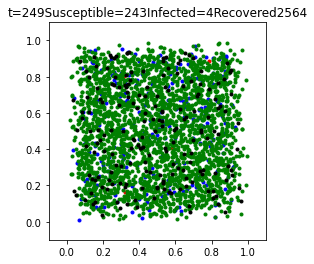

In [20]:
run_model(TIME)

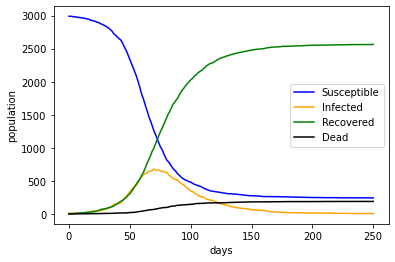

In [26]:
t=np.linspace(0,TIME,TIME)
pyplot.plot(t,cumulative_blue,label = "Susceptible",color="blue")
pyplot.plot(t,cumulative_red,label="Infected",color="orange")
pyplot.plot(t,cumulative_green,label="Recovered",color="green")
pyplot.plot(t,cumulative_black,label="Dead",color = "black")
pyplot.xlabel("days")
pyplot.ylabel("population")
pyplot.legend()

In [27]:
print(max(cumulative_red))
print(t_intervention)

675
10000


In [28]:
max(cumulative_red)

675

In [29]:
for i in range(0,len(cumulative_red)):
    if cumulative_red[i]==max(cumulative_red):
        print(i) ### peak infected time

70


In [31]:
print("N_1","S",cumulative_blue,"I",
cumulative_red,"R",
cumulative_green,"D",
cumulative_black)

N_1 S [2990, 2990, 2988, 2986, 2984, 2981, 2978, 2974, 2971, 2970, 2967, 2966, 2962, 2959, 2953, 2951, 2945, 2939, 2932, 2923, 2920, 2917, 2909, 2900, 2896, 2888, 2878, 2868, 2860, 2850, 2841, 2831, 2815, 2805, 2785, 2770, 2745, 2719, 2707, 2686, 2669, 2651, 2638, 2613, 2579, 2538, 2500, 2468, 2421, 2370, 2328, 2282, 2230, 2187, 2137, 2095, 2038, 1978, 1916, 1841, 1786, 1737, 1673, 1612, 1558, 1495, 1441, 1395, 1338, 1286, 1233, 1194, 1145, 1099, 1051, 1009, 982, 936, 893, 856, 816, 795, 776, 747, 720, 690, 670, 653, 630, 604, 591, 572, 552, 539, 527, 514, 508, 500, 488, 486, 477, 464, 453, 446, 438, 432, 428, 417, 415, 402, 391, 384, 375, 367, 361, 353, 347, 346, 343, 339, 335, 333, 330, 328, 324, 322, 317, 316, 312, 309, 306, 306, 304, 304, 302, 300, 299, 298, 297, 293, 292, 291, 288, 287, 282, 282, 279, 276, 276, 276, 275, 274, 272, 271, 270, 269, 268, 268, 264, 263, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 261, 261, 260, 260, 259, 259, 259, 258, 258, 258, 257, 256, 255, 25